In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import re

from pathlib import Path

In [3]:
import sys
sys.path.insert(0, "./../")

In [4]:
import references_detection.transforms as TL
from references_detection import coco_utils

In [5]:
from src.test_tools import test_model_on_dataset, get_model_prediction_one_image, test_models, get_inference_time
from src.visualization_tools import show_instance_segmentation_by_model_predictions
from src.model import get_model_instance_segmentation, load_model
from src.visualization_tools import show_coco_dataset_item, get_float_image, show_img

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device('cpu')
num_classes = 2

## Датасеты для тестирвания

In [7]:
data_path = Path("/home/ludmila/Projects/Mask_RCNN_PyTorch/data")
coco_dataset_path = data_path / "COCO/val2017"
coco_person_annotations_val = data_path / "COCO/annotations_trainval2017/annotations/person_annotations/val.json"
coco_annotations_val = data_path / "COCO/annotations_trainval2017/annotations/instances_val2017.json"
cityscapes_dataset_path = data_path / "cityscapes"
cityscapes_annotations_val = data_path / "cityscapes/annotations/person_annotations_val.json"
eval_dataset_path = data_path / "tiny"
results_path = Path('./../results')

In [8]:
common_transforms = TL.Compose([coco_utils.ConvertCocoPolysToMask(), TL.ToTensor()])

In [9]:
coco_dataset_full = coco_utils.get_coco_subset_all_annotations(
    coco_dataset_path, coco_annotations_val, common_transforms
)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [10]:
coco_dataset_person = coco_utils.get_coco_subset_all_annotations(
    coco_dataset_path, coco_person_annotations_val, common_transforms
)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [11]:
cityscapes_dataset = coco_utils.get_coco_subset_all_annotations(
    cityscapes_dataset_path, cityscapes_annotations_val, common_transforms
)

loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


## Тестирование

### Дообученная модель

In [12]:
model_tag = "mask_rcnn_cityscapes_training_adam"

In [13]:
datasets = {'cityscapes_dataset': cityscapes_dataset}

In [14]:
models_paths = list((results_path / model_tag / 'models').glob('*_[3, 5, 7].pth'))
models = map(load_model, [2] * len(models_paths), models_paths)
m = zip([x.stem for x in models_paths], models)

In [ ]:
results = test_models(m, datasets, device)

In [16]:
with open(results_path / model_tag / 'results.json', "w") as fp:
    json.dump(results, fp) 

### Предобученный maskrcnn

In [12]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=91)

In [13]:
model_tag = 'mask_rcnn'

In [14]:
datasets = {'cityscapes_dataset': cityscapes_dataset, 'coco_dataset_person': coco_dataset_person}

In [ ]:
results = test_models([(model_tag, model)], datasets, device)

In [16]:
with open(results_path / model_tag / 'results.json', "w") as fp:
    json.dump(results , fp) 

## Инференс

In [37]:
model_tag = 'mask_rcnn_cityscapes_training_adam'
img = get_float_image(eval_dataset_path / 'image_4.png')
model = load_model(2, results_path / model_tag / 'models' / "mask_rcnn_cityscapes_training_adam_7.pth")

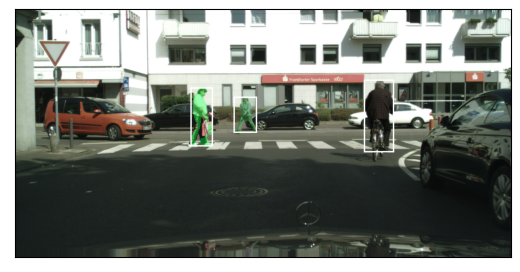

0.32442784309387207


In [38]:
time = get_inference_time(img, model, device)
show_instance_segmentation_by_model_predictions(img, get_model_prediction_one_image(img, model, device), alpha=0.4, score_thres=0.7)
plt.show()
print(time)

In [39]:
model_tag = 'mask_rcnn_coco_person_training_sgd_lr_00005_trainable_backbone_layers_2'
img = get_float_image(eval_dataset_path / 'image_2.jpg')
model = load_model(2, results_path / model_tag / 'models' / "mask_rcnn_coco_person_training_sgd_lr_00005_trainable_backbone_layers_2_9.pth")

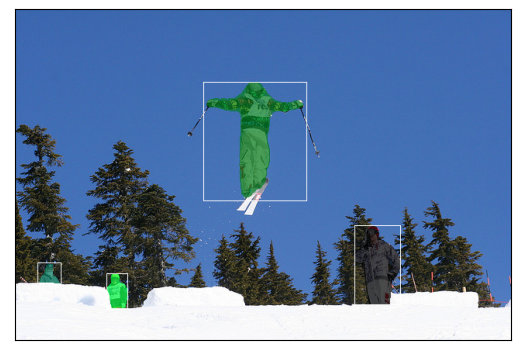

0.3400230407714844


In [42]:
time = get_inference_time(img, model, device)
show_instance_segmentation_by_model_predictions(img, get_model_prediction_one_image(img, model, device), alpha=0.7, score_thres=0.84, width=1)
plt.show()
print(time)